# Tier 0: CNN + BRNN Training

This notebook implements training for the **Tier 0** architecture:
- Multi-scale 1D CNN for local feature extraction
- Stacked Bidirectional vanilla RNN for sequential modeling
- Dual output heads for Q8 and Q3 prediction

This is a simpler baseline compared to Tier 1's BiLSTM.

## Expected Performance
- Q3 Accuracy: ~80-83%
- Q8 Accuracy: ~68-72%

## 1. Setup & Configuration

In [1]:
import sys
sys.path.insert(0, '../..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import random
import os

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Import our modules
from src.config import Tier0Config, LEAKAGE_TRAIN_IDS
from src.data import ProteinDataset, create_dataloaders, collate_fn
from src.models.tier0_cnn_brnn import CNNBRNN
from src.losses import get_multitask_loss
from src.augmentation import SequenceAugmenter, describe_augmentation_levels
from src.metrics import evaluate_model, plot_confusion_matrix, EvaluationReport
from src.training import Trainer, create_optimizer, create_scheduler, plot_training_history

## 2. Configuration

In [3]:
# Experiment configuration
config = Tier0Config(
    # Data
    max_seq_length=512,
    batch_size=32,
    
    # Model
    input_dim=40,  # 20 (one-hot) + 20 (BLOSUM62)
    use_blosum=True,
    cnn_filters=64,
    cnn_kernels=[3, 5, 7],
    rnn_hidden=256,
    rnn_layers=2,
    rnn_dropout=0.1,
    rnn_nonlinearity='tanh',
    fc_hidden=256,
    fc_dropout=0.1,
    
    # Training
    learning_rate=1e-4,
    weight_decay=0.01,
    max_epochs=50,
    patience=10,
    gradient_clip=1.0,
    
    # Loss
    focal_gamma=2.0,
    q8_loss_weight=1.0,
    q3_loss_weight=0.5,
    
    # Augmentation
    augmentation_level=1,  # Light masking
    
    # Checkpointing
    checkpoint_dir='../../checkpoints/tier0_cnn_brnn',
)

print("Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Batch size: {config.batch_size}")
print(f"  Max sequence length: {config.max_seq_length}")
print(f"  Learning rate: {config.learning_rate}")
print(f"  RNN nonlinearity: {config.rnn_nonlinearity}")
print(f"  Augmentation level: {config.augmentation_level}")

Configuration:
  Model: tier0_cnn_brnn
  Batch size: 32
  Max sequence length: 512
  Learning rate: 0.0001
  RNN nonlinearity: tanh
  Augmentation level: 1


## 3. Data Loading

In [4]:
# Preview augmentation levels
describe_augmentation_levels()

AUGMENTATION LEVELS

Level 1: No augmentation (baseline)
  - Mask prob: 0.0
  - Substitute prob: 0.0
  - Crop prob: 0.0
  - Noise std: 0.0
  - Reverse prob: 0.0

Level 2: Light masking (5%)
  - Mask prob: 0.05
  - Substitute prob: 0.0
  - Crop prob: 0.0
  - Noise std: 0.0
  - Reverse prob: 0.0

Level 3: Moderate: masking (10%) + substitution (3%) + noise
  - Mask prob: 0.1
  - Substitute prob: 0.03
  - Crop prob: 0.0
  - Noise std: 0.01
  - Reverse prob: 0.0

Level 4: Aggressive: masking (15%) + substitution (5%) + cropping (20%)
  - Mask prob: 0.15
  - Substitute prob: 0.05
  - Crop prob: 0.2
  - Noise std: 0.02
  - Reverse prob: 0.0

Level 5: Experimental: heavy masking (20%) + all augmentations + reversal (10%)
  - Mask prob: 0.2
  - Substitute prob: 0.08
  - Crop prob: 0.3
  - Noise std: 0.03
  - Reverse prob: 0.1


In [5]:
# Create augmenter
augmenter = SequenceAugmenter(level=config.augmentation_level, seed=SEED)
print(f"\nUsing augmentation: {augmenter}")


Using augmentation: SequenceAugmenter(level=1, config=AugmentationConfig(mask_prob=0.0, substitute_prob=0.0, noise_std=0.0, crop_prob=0.0, min_crop_ratio=0.8, reverse_prob=0.0))


In [6]:
# Create data loaders
train_loader, val_loader = create_dataloaders(
    train_csv='../../data/train.csv',
    val_split=0.1,
    batch_size=config.batch_size,
    max_length=config.max_seq_length,
    use_blosum=config.use_blosum,
    use_positional=False,
    augmentation=augmenter,
    num_workers=4,
    seed=SEED,
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 205
Val batches: 23


In [7]:
# Inspect a batch
sample_batch = next(iter(train_loader))
print(f"\nBatch contents:")
print(f"  Features shape: {sample_batch['features'].shape}")
print(f"  SST8 shape: {sample_batch['sst8'].shape}")
print(f"  SST3 shape: {sample_batch['sst3'].shape}")
print(f"  Lengths: {sample_batch['lengths'][:5]}")


Batch contents:
  Features shape: torch.Size([32, 512, 40])
  SST8 shape: torch.Size([32, 512])
  SST3 shape: torch.Size([32, 512])
  Lengths: tensor([512, 512, 512, 497, 393])


## 4. Model Initialization

In [8]:
# Create model
model = CNNBRNN(
    input_dim=config.input_dim,
    cnn_filters=config.cnn_filters,
    cnn_kernels=config.cnn_kernels,
    rnn_hidden=config.rnn_hidden,
    rnn_layers=config.rnn_layers,
    rnn_dropout=config.rnn_dropout,
    rnn_nonlinearity=config.rnn_nonlinearity,
    fc_hidden=config.fc_hidden,
    fc_dropout=config.fc_dropout,
)

print(model)
print(f"\nTotal parameters: {model.count_parameters():,}")

CNNBRNN(
  CNN: 192 channels
  BiRNN: 512 hidden
  Parameters: 929,099
)

Total parameters: 929,099


In [9]:
# Test forward pass
model = model.to(DEVICE)
test_input = sample_batch['features'].to(DEVICE)
q8_out, q3_out = model(test_input)
print(f"Q8 output shape: {q8_out.shape}")
print(f"Q3 output shape: {q3_out.shape}")

Q8 output shape: torch.Size([32, 512, 8])
Q3 output shape: torch.Size([32, 512, 3])


## 5. Loss Function Setup

In [10]:
# Create multi-task loss with focal loss and class weights
loss_fn = get_multitask_loss(
    loss_type='focal',
    q8_weight=config.q8_loss_weight,
    q3_weight=config.q3_loss_weight,
    dynamic_weights=False,
    gamma=config.focal_gamma,
)

print(f"Loss function: {loss_fn}")

Loss function: MultiTaskLoss(
  (q8_loss_fn): FocalLoss()
  (q3_loss_fn): FocalLoss()
)


## 6. Training

In [11]:
# Create optimizer and scheduler
optimizer = create_optimizer(
    model,
    lr=config.learning_rate,
    weight_decay=config.weight_decay,
    optimizer_type='adamw',
)

scheduler = create_scheduler(
    optimizer,
    scheduler_type='cosine',
    num_epochs=config.max_epochs,
)

In [12]:
# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    checkpoint_dir=config.checkpoint_dir,
    gradient_clip=config.gradient_clip,
    log_every=100,
    use_amp=torch.cuda.is_available(),  # Use FP16 on GPU
    use_tracking=True,
    trackio_space_id='thethinkmachine/trackio',  # HuggingFace Space for logs
    experiment_name='tier0_cnn_brnn',
    hub_model_id='thethinkmachine/ProteinSST-CNNBRNN',
    training_config=config,
)

In [13]:
# Train!
history = trainer.train(
    num_epochs=config.max_epochs,
    patience=config.patience,
    save_every=5,
)

📊 Logging to HuggingFace Space: thethinkmachine/trackio
* Trackio project initialized: tier0_cnn_brnn
* Trackio metrics will be synced to Hugging Face Dataset: thethinkmachine/trackio-dataset
* Found existing space: https://huggingface.co/spaces/thethinkmachine/trackio
* View dashboard by going to: https://thethinkmachine-trackio.hf.space/


* Created new run: thethinkmachine-1765719112
✓ Experiment tracking enabled (Trackio)
Starting training for 50 epochs...
Device: cuda
Model parameters: 929,099


Epoch 1: 100%|██████████| 205/205 [00:04<00:00, 41.60it/s, loss=0.955, q8_loss=0.809, q3_loss=0.292]


Epoch 1/50 (5.5s) | Train Loss: 1.0768 | Val Loss: 0.9403 | Q8 Acc: 0.4048 | Q3 Acc: 0.6243 | Q8 F1: 0.2630 | Q3 F1: 0.6127 | H-F1: 0.3680 | LR: 0.000099 *


Epoch 2: 100%|██████████| 205/205 [00:04<00:00, 44.70it/s, loss=1.24, q8_loss=1.12, q3_loss=0.23]   


Epoch 2/50 (5.1s) | Train Loss: 0.9586 | Val Loss: 0.8832 | Q8 Acc: 0.4486 | Q3 Acc: 0.6532 | Q8 F1: 0.2893 | Q3 F1: 0.6467 | H-F1: 0.3998 | LR: 0.000096 *


Epoch 3: 100%|██████████| 205/205 [00:04<00:00, 46.28it/s, loss=1.05, q8_loss=0.916, q3_loss=0.274] 


Epoch 3/50 (5.0s) | Train Loss: 0.9271 | Val Loss: 0.8649 | Q8 Acc: 0.4389 | Q3 Acc: 0.6621 | Q8 F1: 0.2918 | Q3 F1: 0.6564 | H-F1: 0.4039 | LR: 0.000092 *


Epoch 4: 100%|██████████| 205/205 [00:04<00:00, 47.03it/s, loss=0.941, q8_loss=0.808, q3_loss=0.265]


Epoch 4/50 (4.9s) | Train Loss: 0.9104 | Val Loss: 0.8556 | Q8 Acc: 0.4419 | Q3 Acc: 0.6582 | Q8 F1: 0.2935 | Q3 F1: 0.6546 | H-F1: 0.4053 | LR: 0.000086 *


Epoch 5:  50%|████▉     | 102/205 [00:02<00:02, 49.26it/s, loss=0.901, q8_loss=0.776, q3_loss=0.249]Traceback (most recent call last):
  File "/usr/lib64/python3.13/threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "/usr/lib64/python3.13/threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shreyanc/Documents/ekman-emotions/.venv/lib64/python3.13/site-packages/trackio/run.py", line 111, in _init_client_background
    self._batch_sender()
    ~~~~~~~~~~~~~~~~~~^^
  File "/home/shreyanc/Documents/ekman-emotions/.venv/lib64/python3.13/site-packages/trackio/run.py", line 82, in _batch_sender
    self._client.predict(
    ~~~~~~~~~~~~~~~~~~~~^
        api_name="/bulk_log",
        ^^^^^^^^^^^^^^^^^^^^^
        logs=logs_to_send,
        ^^^^^^^^^^^^^^^^^^
        hf_token=huggingface_hub.utils.get_token(),
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File

Epoch 5/50 (4.9s) | Train Loss: 0.8984 | Val Loss: 0.8504 | Q8 Acc: 0.4650 | Q3 Acc: 0.6689 | Q8 F1: 0.3043 | Q3 F1: 0.6617 | H-F1: 0.4169 | LR: 0.000078 *


Epoch 6: 100%|██████████| 205/205 [00:04<00:00, 46.29it/s, loss=0.958, q8_loss=0.853, q3_loss=0.21] 


Epoch 6/50 (5.0s) | Train Loss: 0.8896 | Val Loss: 0.8426 | Q8 Acc: 0.4612 | Q3 Acc: 0.6721 | Q8 F1: 0.3057 | Q3 F1: 0.6669 | H-F1: 0.4193 | LR: 0.000069 *


Epoch 7: 100%|██████████| 205/205 [00:04<00:00, 46.51it/s, loss=0.864, q8_loss=0.721, q3_loss=0.287]


Epoch 7/50 (4.9s) | Train Loss: 0.8812 | Val Loss: 0.8394 | Q8 Acc: 0.4676 | Q3 Acc: 0.6618 | Q8 F1: 0.3056 | Q3 F1: 0.6583 | H-F1: 0.4174 | LR: 0.000060


Epoch 8: 100%|██████████| 205/205 [00:04<00:00, 46.71it/s, loss=0.87, q8_loss=0.748, q3_loss=0.242] 


Epoch 8/50 (4.9s) | Train Loss: 0.8749 | Val Loss: 0.8393 | Q8 Acc: 0.4537 | Q3 Acc: 0.6616 | Q8 F1: 0.3033 | Q3 F1: 0.6589 | H-F1: 0.4154 | LR: 0.000051


Epoch 9: 100%|██████████| 205/205 [00:04<00:00, 46.52it/s, loss=0.922, q8_loss=0.784, q3_loss=0.275]


Epoch 9/50 (4.9s) | Train Loss: 0.8679 | Val Loss: 0.8423 | Q8 Acc: 0.4742 | Q3 Acc: 0.6690 | Q8 F1: 0.3069 | Q3 F1: 0.6606 | H-F1: 0.4191 | LR: 0.000041


Epoch 10: 100%|██████████| 205/205 [00:04<00:00, 47.09it/s, loss=0.822, q8_loss=0.704, q3_loss=0.235]


Epoch 10/50 (4.9s) | Train Loss: 0.8621 | Val Loss: 0.8274 | Q8 Acc: 0.4754 | Q3 Acc: 0.6732 | Q8 F1: 0.3116 | Q3 F1: 0.6681 | H-F1: 0.4250 | LR: 0.000032 *


Epoch 11: 100%|██████████| 205/205 [00:04<00:00, 46.74it/s, loss=0.953, q8_loss=0.828, q3_loss=0.249]


Epoch 11/50 (4.9s) | Train Loss: 0.8573 | Val Loss: 0.8264 | Q8 Acc: 0.4736 | Q3 Acc: 0.6699 | Q8 F1: 0.3112 | Q3 F1: 0.6664 | H-F1: 0.4243 | LR: 0.000023


Epoch 12: 100%|██████████| 205/205 [00:04<00:00, 46.70it/s, loss=0.801, q8_loss=0.679, q3_loss=0.245]


Epoch 12/50 (4.9s) | Train Loss: 0.8539 | Val Loss: 0.8244 | Q8 Acc: 0.4758 | Q3 Acc: 0.6768 | Q8 F1: 0.3130 | Q3 F1: 0.6712 | H-F1: 0.4269 | LR: 0.000015 *


Epoch 13: 100%|██████████| 205/205 [00:04<00:00, 46.87it/s, loss=0.886, q8_loss=0.758, q3_loss=0.256]


Epoch 13/50 (4.9s) | Train Loss: 0.8505 | Val Loss: 0.8240 | Q8 Acc: 0.4753 | Q3 Acc: 0.6739 | Q8 F1: 0.3117 | Q3 F1: 0.6690 | H-F1: 0.4253 | LR: 0.000009


Epoch 14: 100%|██████████| 205/205 [00:04<00:00, 46.70it/s, loss=0.952, q8_loss=0.827, q3_loss=0.25] 


Epoch 14/50 (4.9s) | Train Loss: 0.8487 | Val Loss: 0.8224 | Q8 Acc: 0.4751 | Q3 Acc: 0.6769 | Q8 F1: 0.3131 | Q3 F1: 0.6718 | H-F1: 0.4272 | LR: 0.000005 *


Epoch 15: 100%|██████████| 205/205 [00:04<00:00, 47.22it/s, loss=0.917, q8_loss=0.803, q3_loss=0.228]


Epoch 15/50 (4.9s) | Train Loss: 0.8473 | Val Loss: 0.8223 | Q8 Acc: 0.4786 | Q3 Acc: 0.6759 | Q8 F1: 0.3140 | Q3 F1: 0.6706 | H-F1: 0.4278 | LR: 0.000002 *


Epoch 16: 100%|██████████| 205/205 [00:04<00:00, 46.55it/s, loss=0.827, q8_loss=0.696, q3_loss=0.261]


Epoch 16/50 (4.9s) | Train Loss: 0.8463 | Val Loss: 0.8233 | Q8 Acc: 0.4710 | Q3 Acc: 0.6780 | Q8 F1: 0.3119 | Q3 F1: 0.6722 | H-F1: 0.4261 | LR: 0.000100


Epoch 17: 100%|██████████| 205/205 [00:04<00:00, 46.80it/s, loss=0.926, q8_loss=0.806, q3_loss=0.24] 


Epoch 17/50 (4.9s) | Train Loss: 0.8544 | Val Loss: 0.8287 | Q8 Acc: 0.4494 | Q3 Acc: 0.6836 | Q8 F1: 0.3049 | Q3 F1: 0.6764 | H-F1: 0.4203 | LR: 0.000100


Epoch 18: 100%|██████████| 205/205 [00:04<00:00, 47.06it/s, loss=0.916, q8_loss=0.772, q3_loss=0.287]


Epoch 18/50 (4.8s) | Train Loss: 0.8487 | Val Loss: 0.8212 | Q8 Acc: 0.4519 | Q3 Acc: 0.6824 | Q8 F1: 0.3069 | Q3 F1: 0.6777 | H-F1: 0.4225 | LR: 0.000099


Epoch 19: 100%|██████████| 205/205 [00:04<00:00, 46.88it/s, loss=0.779, q8_loss=0.665, q3_loss=0.23] 


Epoch 19/50 (4.9s) | Train Loss: 0.8424 | Val Loss: 0.8186 | Q8 Acc: 0.4663 | Q3 Acc: 0.6780 | Q8 F1: 0.3118 | Q3 F1: 0.6730 | H-F1: 0.4262 | LR: 0.000098


Epoch 20: 100%|██████████| 205/205 [00:04<00:00, 46.81it/s, loss=0.805, q8_loss=0.669, q3_loss=0.272]


Epoch 20/50 (4.9s) | Train Loss: 0.8384 | Val Loss: 0.8374 | Q8 Acc: 0.4747 | Q3 Acc: 0.6746 | Q8 F1: 0.3143 | Q3 F1: 0.6652 | H-F1: 0.4269 | LR: 0.000096


Epoch 21: 100%|██████████| 205/205 [00:04<00:00, 47.02it/s, loss=0.769, q8_loss=0.658, q3_loss=0.22] 


Epoch 21/50 (4.9s) | Train Loss: 0.8304 | Val Loss: 0.8105 | Q8 Acc: 0.4837 | Q3 Acc: 0.6750 | Q8 F1: 0.3177 | Q3 F1: 0.6722 | H-F1: 0.4315 | LR: 0.000094 *


Epoch 22: 100%|██████████| 205/205 [00:04<00:00, 47.22it/s, loss=0.895, q8_loss=0.771, q3_loss=0.248]


Epoch 22/50 (4.9s) | Train Loss: 0.8238 | Val Loss: 0.8265 | Q8 Acc: 0.4851 | Q3 Acc: 0.6840 | Q8 F1: 0.3199 | Q3 F1: 0.6747 | H-F1: 0.4340 | LR: 0.000092 *


Epoch 23: 100%|██████████| 205/205 [00:04<00:00, 47.15it/s, loss=0.742, q8_loss=0.617, q3_loss=0.249]


Epoch 23/50 (4.9s) | Train Loss: 0.8182 | Val Loss: 0.8113 | Q8 Acc: 0.4860 | Q3 Acc: 0.6862 | Q8 F1: 0.3194 | Q3 F1: 0.6796 | H-F1: 0.4345 | LR: 0.000089 *


Epoch 24: 100%|██████████| 205/205 [00:04<00:00, 46.81it/s, loss=0.896, q8_loss=0.767, q3_loss=0.258]


Epoch 24/50 (4.9s) | Train Loss: 0.8107 | Val Loss: 0.8263 | Q8 Acc: 0.4850 | Q3 Acc: 0.6561 | Q8 F1: 0.3163 | Q3 F1: 0.6560 | H-F1: 0.4268 | LR: 0.000086


Epoch 25: 100%|██████████| 205/205 [00:04<00:00, 46.71it/s, loss=0.81, q8_loss=0.689, q3_loss=0.242] 


Epoch 25/50 (4.9s) | Train Loss: 0.8062 | Val Loss: 0.8172 | Q8 Acc: 0.4882 | Q3 Acc: 0.6878 | Q8 F1: 0.3232 | Q3 F1: 0.6797 | H-F1: 0.4381 | LR: 0.000082 *


Epoch 26: 100%|██████████| 205/205 [00:04<00:00, 46.66it/s, loss=0.738, q8_loss=0.624, q3_loss=0.228]


Epoch 26/50 (4.9s) | Train Loss: 0.8006 | Val Loss: 0.8052 | Q8 Acc: 0.4957 | Q3 Acc: 0.6858 | Q8 F1: 0.3261 | Q3 F1: 0.6816 | H-F1: 0.4411 | LR: 0.000078 *


Epoch 27: 100%|██████████| 205/205 [00:04<00:00, 47.70it/s, loss=0.774, q8_loss=0.67, q3_loss=0.209] 


Epoch 27/50 (4.8s) | Train Loss: 0.7956 | Val Loss: 0.8026 | Q8 Acc: 0.4800 | Q3 Acc: 0.6861 | Q8 F1: 0.3181 | Q3 F1: 0.6809 | H-F1: 0.4336 | LR: 0.000074


Epoch 28: 100%|██████████| 205/205 [00:04<00:00, 46.79it/s, loss=0.783, q8_loss=0.671, q3_loss=0.225]


Epoch 28/50 (4.9s) | Train Loss: 0.7930 | Val Loss: 0.8218 | Q8 Acc: 0.4665 | Q3 Acc: 0.6698 | Q8 F1: 0.3142 | Q3 F1: 0.6683 | H-F1: 0.4274 | LR: 0.000069


Epoch 29: 100%|██████████| 205/205 [00:04<00:00, 46.50it/s, loss=0.736, q8_loss=0.633, q3_loss=0.206]


Epoch 29/50 (4.9s) | Train Loss: 0.7880 | Val Loss: 0.8013 | Q8 Acc: 0.4838 | Q3 Acc: 0.6926 | Q8 F1: 0.3223 | Q3 F1: 0.6876 | H-F1: 0.4389 | LR: 0.000065


Epoch 30: 100%|██████████| 205/205 [00:04<00:00, 47.07it/s, loss=0.753, q8_loss=0.648, q3_loss=0.21] 


Epoch 30/50 (4.8s) | Train Loss: 0.7820 | Val Loss: 0.8015 | Q8 Acc: 0.4855 | Q3 Acc: 0.6912 | Q8 F1: 0.3226 | Q3 F1: 0.6860 | H-F1: 0.4388 | LR: 0.000060


Epoch 31: 100%|██████████| 205/205 [00:04<00:00, 46.94it/s, loss=0.733, q8_loss=0.619, q3_loss=0.228]


Epoch 31/50 (4.9s) | Train Loss: 0.7779 | Val Loss: 0.8016 | Q8 Acc: 0.4824 | Q3 Acc: 0.6915 | Q8 F1: 0.3215 | Q3 F1: 0.6867 | H-F1: 0.4380 | LR: 0.000055


Epoch 32: 100%|██████████| 205/205 [00:04<00:00, 46.63it/s, loss=0.746, q8_loss=0.636, q3_loss=0.22] 


Epoch 32/50 (4.9s) | Train Loss: 0.7742 | Val Loss: 0.8086 | Q8 Acc: 0.4889 | Q3 Acc: 0.6776 | Q8 F1: 0.3219 | Q3 F1: 0.6757 | H-F1: 0.4360 | LR: 0.000051


Epoch 33: 100%|██████████| 205/205 [00:04<00:00, 46.97it/s, loss=0.795, q8_loss=0.683, q3_loss=0.224]


Epoch 33/50 (4.8s) | Train Loss: 0.7724 | Val Loss: 0.8038 | Q8 Acc: 0.4857 | Q3 Acc: 0.6927 | Q8 F1: 0.3237 | Q3 F1: 0.6875 | H-F1: 0.4402 | LR: 0.000046


Epoch 34: 100%|██████████| 205/205 [00:04<00:00, 46.71it/s, loss=0.782, q8_loss=0.671, q3_loss=0.221]


Epoch 34/50 (4.9s) | Train Loss: 0.7680 | Val Loss: 0.8012 | Q8 Acc: 0.4919 | Q3 Acc: 0.6872 | Q8 F1: 0.3246 | Q3 F1: 0.6836 | H-F1: 0.4402 | LR: 0.000041


Epoch 35: 100%|██████████| 205/205 [00:04<00:00, 47.12it/s, loss=0.697, q8_loss=0.593, q3_loss=0.209]


Epoch 35/50 (4.8s) | Train Loss: 0.7651 | Val Loss: 0.8015 | Q8 Acc: 0.4862 | Q3 Acc: 0.6920 | Q8 F1: 0.3226 | Q3 F1: 0.6869 | H-F1: 0.4390 | LR: 0.000036


Epoch 36: 100%|██████████| 205/205 [00:04<00:00, 46.53it/s, loss=0.784, q8_loss=0.665, q3_loss=0.237]


Epoch 36/50 (4.9s) | Train Loss: 0.7619 | Val Loss: 0.8033 | Q8 Acc: 0.4912 | Q3 Acc: 0.6904 | Q8 F1: 0.3241 | Q3 F1: 0.6859 | H-F1: 0.4402 | LR: 0.000032

Early stopping triggered at epoch 36
* Run finished. Uploading logs to Trackio (please wait...)
✓ Experiment tracking finished


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

✓ Model pushed to: https://huggingface.co/thethinkmachine/ProteinSST-CNNBRNN

Training complete!
Best Harmonic F1: 0.4411
Best Q8 F1: 0.3261
Best Q8 Accuracy: 0.4957
Best Val Loss: 0.8052


## 7. Training Visualization

/tmp/ipykernel_436481/661974001.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


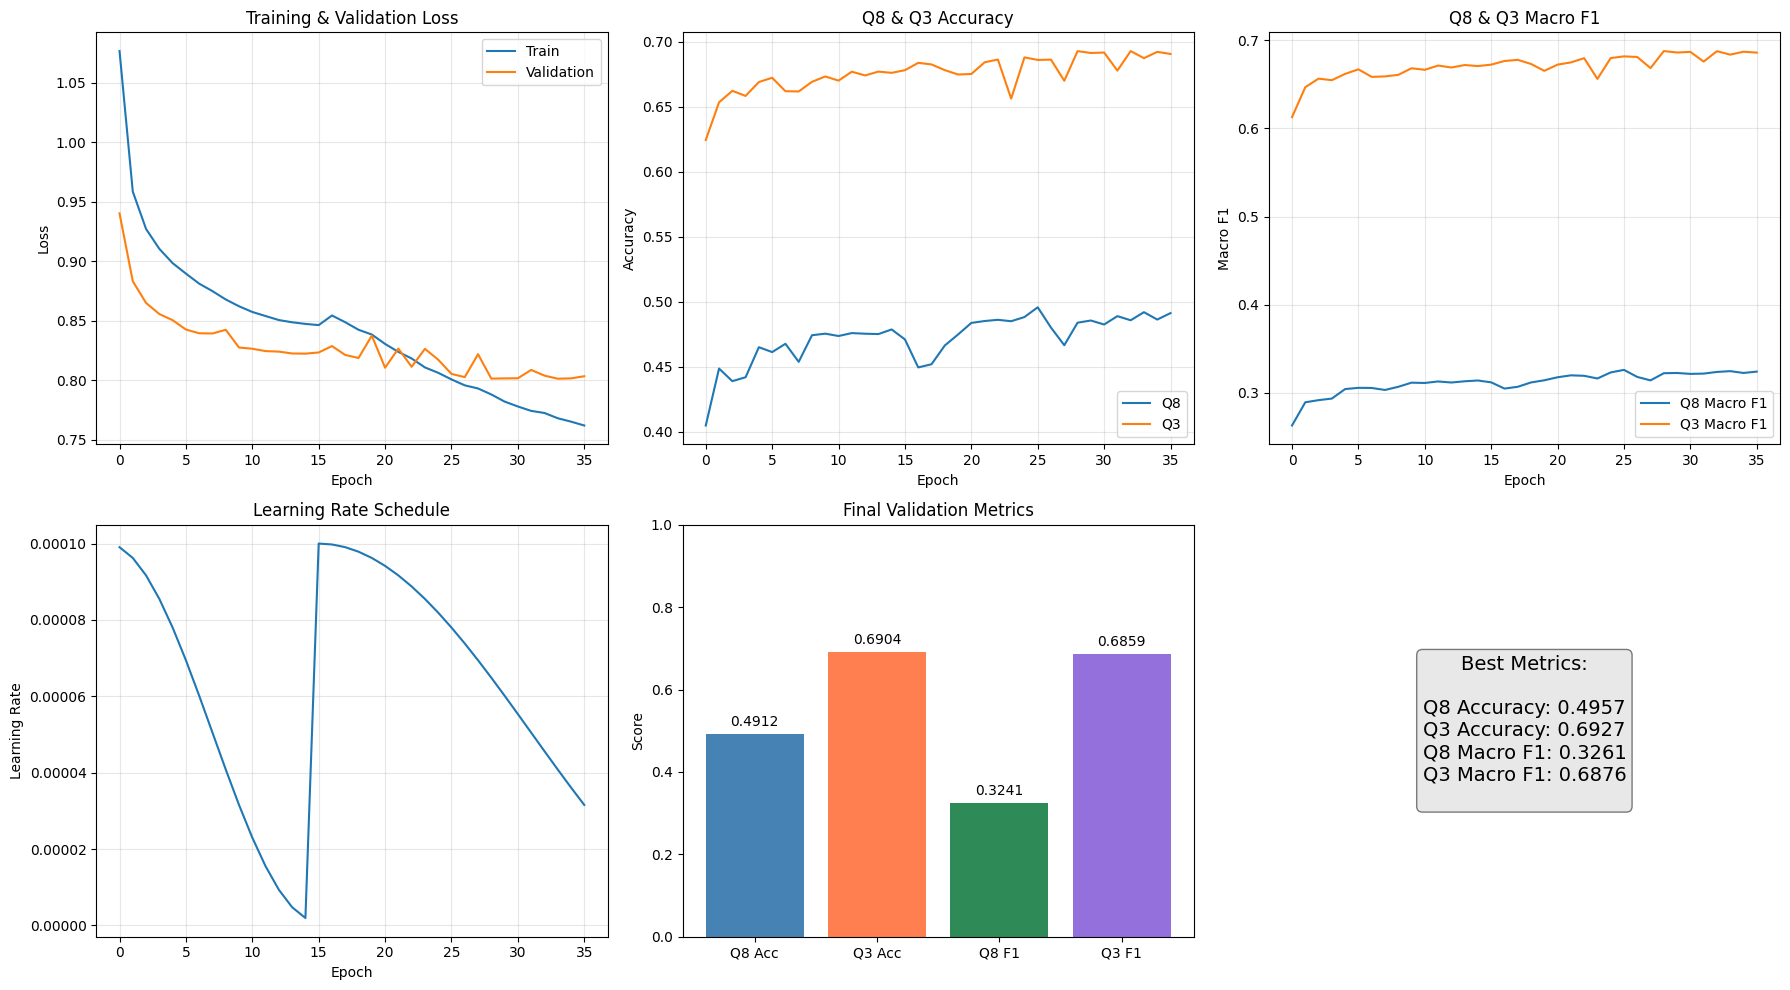

In [14]:
# Plot training history
fig = plot_training_history(history, save_path=f'{config.checkpoint_dir}/training_history.png')
fig.show()

## 8. Evaluation

In [15]:
# Load best model
checkpoint = torch.load(f'{config.checkpoint_dir}/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

Loaded best model from epoch 26


In [16]:
# Full evaluation
report = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=DEVICE,
    compute_sov=True,
)

report.print_report()

EVALUATION REPORT

============================== Q8 (8-state) ==============================
Accuracy: 0.4957 (49.57%)
Macro F1: 0.3261
SOV Score: 54.84

Per-class metrics:
Class           Precision    Recall       F1           Support   
------------------------------------------------------------
G (3₁₀-helix)   0.1156       0.4433       0.1833       6420
H (α-helix)     0.7673       0.6755       0.7185       52250
I (π-helix)     0.0000       0.0000       0.0000       23
E (β-strand)    0.5970       0.6418       0.6186       37526
B (β-bridge)    0.0409       0.2803       0.0715       1809
T (Turn)        0.3495       0.4630       0.3983       18325
S (Bend)        0.2834       0.1883       0.2262       13162
C (Coil)        0.7691       0.2632       0.3922       40857

============================== Q3 (3-state) ==============================
Accuracy: 0.6858 (68.58%)
Macro F1: 0.6816
SOV Score: 73.15

Per-class metrics:
Class           Precision    Recall       F1           Suppo

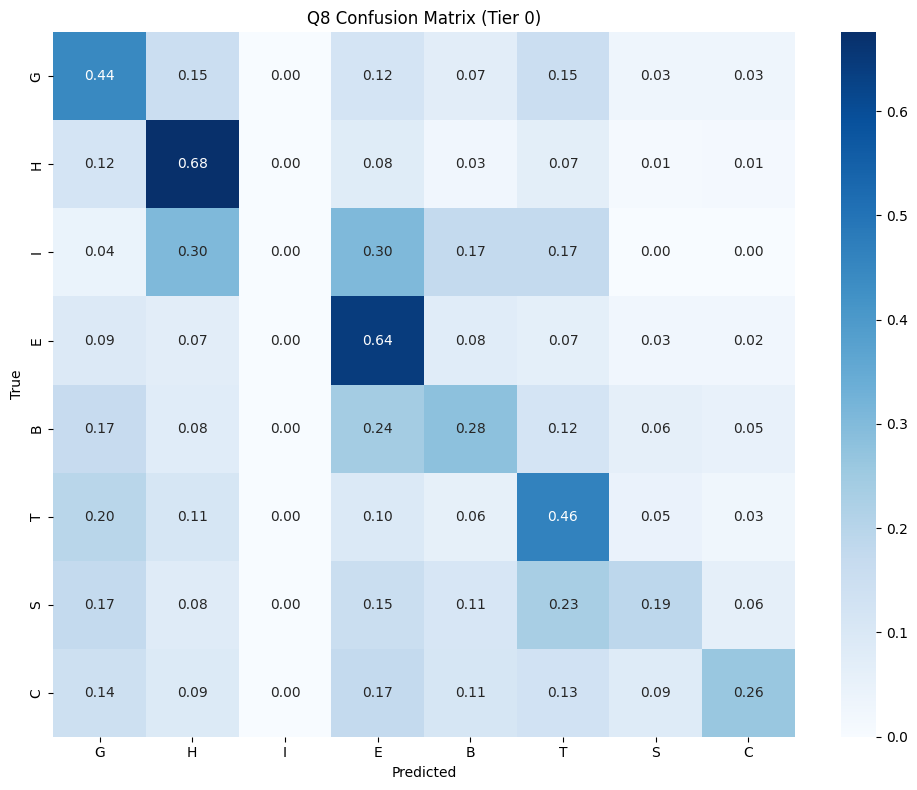

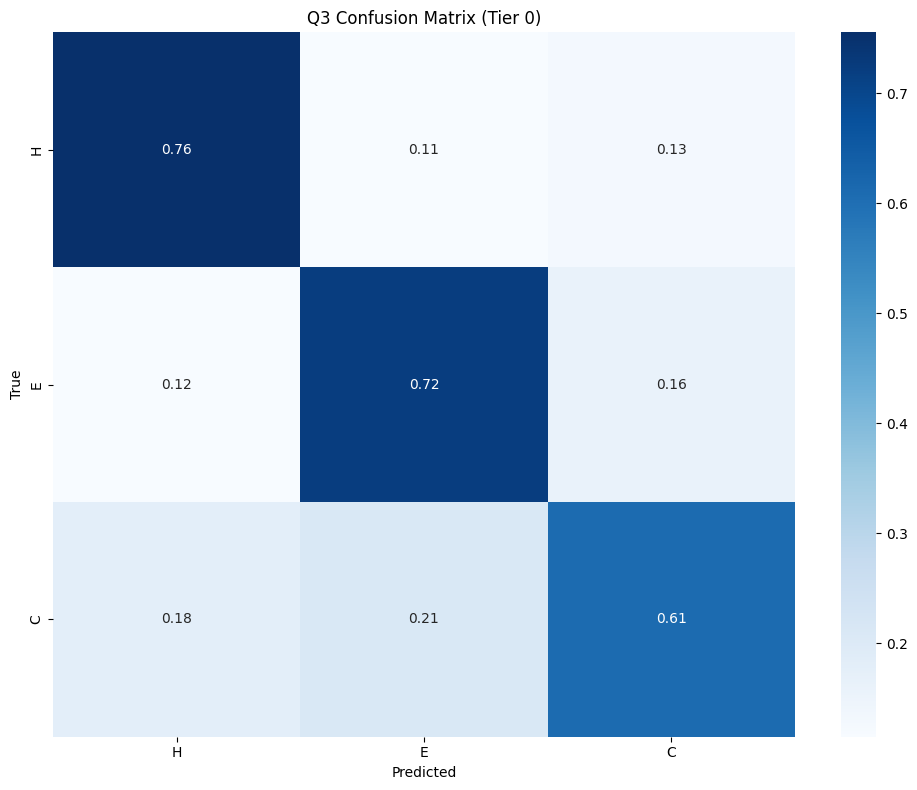

In [17]:
# Plot confusion matrices
from src.config import SST8_CLASSES, SST3_CLASSES

fig_q8 = plot_confusion_matrix(
    report.q8_confusion_matrix,
    SST8_CLASSES,
    title='Q8 Confusion Matrix (Tier 0)',
    save_path=f'{config.checkpoint_dir}/q8_confusion_matrix.png',
)

fig_q3 = plot_confusion_matrix(
    report.q3_confusion_matrix,
    SST3_CLASSES,
    title='Q3 Confusion Matrix (Tier 0)',
    save_path=f'{config.checkpoint_dir}/q3_confusion_matrix.png',
)

## 9. Summary

In [18]:
print("=" * 60)
print("TIER 0 TRAINING COMPLETE")
print("=" * 60)
print(f"\nBest Results:")
print(f"  Q8 Accuracy: {report.q8_accuracy:.4f} ({report.q8_accuracy*100:.2f}%)")
print(f"  Q3 Accuracy: {report.q3_accuracy:.4f} ({report.q3_accuracy*100:.2f}%)")
print(f"  Q8 Macro F1: {report.q8_macro_f1:.4f}")
print(f"  Q3 Macro F1: {report.q3_macro_f1:.4f}")
if report.q8_sov:
    print(f"  Q8 SOV: {report.q8_sov:.2f}")
    print(f"  Q3 SOV: {report.q3_sov:.2f}")

print(f"\nCheckpoints saved to: {config.checkpoint_dir}")

TIER 0 TRAINING COMPLETE

Best Results:
  Q8 Accuracy: 0.4957 (49.57%)
  Q3 Accuracy: 0.6858 (68.58%)
  Q8 Macro F1: 0.3261
  Q3 Macro F1: 0.6816
  Q8 SOV: 54.84
  Q3 SOV: 73.15

Checkpoints saved to: ../../checkpoints/tier0_cnn_brnn
